In [1]:
from IPython.display import display
import os
from PIL import Image
import math
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import fitz
from IPython.display import display
from IPython.display import Image as DisplayImage

import fitz  # Import PyMuPDF
from IPython.display import display  # Import display function
from PIL import Image, ImageDraw, ImageFont  # Import necessary classes from PIL
import io  # Import io module for converting bytes

from tqdm import tqdm
import re

In [2]:
dpi = 300
size_ratio = 1.3
y_range = (39, 575)

In [3]:
def draw_bbox(page, bboxs):

    for bbox in bboxs:  # iterate over all tables
        page.draw_rect(bbox,color=fitz.pdfcolor["blue"], width=1.5)
    pix = page.get_pixmap()  # Render page to an image

    # Convert the pixmap to a PIL Image
    img_bytes = pix.tobytes("png")  # Get the image bytes in PNG format
    img = Image.open(io.BytesIO(img_bytes))
    display(img)
    

In [4]:
def save_image(page, page_num, index, prev_text, bbox, xres, yres, width, height, ext, size_ratio=1.3, dpi=300):
    
    x_scale = dpi /xres  # PyMuPDF의 기본 해상도는 72 DPI입니다.
    y_scale = dpi / yres
    matrix = fitz.Matrix(x_scale, y_scale)  # 변환 행렬 생성
    
    # 선택한 bbox 영역의 이미지를 추출 (해상도 조절 적용)
    pix = page.get_pixmap(matrix=matrix, clip=bbox)
    
    # pix = page.get_pixmap(clip=bbox)
    
    # PIL 이미지로 변환
    image = Image.open(io.BytesIO(pix.tobytes()))
    image = image.resize((int(width*size_ratio), int(height*size_ratio)), Image.Resampling.LANCZOS)
    
    
    # 이미지에 텍스트 추가
    draw = ImageDraw.Draw(image)
    # 폰트는 시스템에 따라 경로가 다를 수 있으며, 필요에 따라 수정해야 할 수 있습니다.
    font = ImageFont.truetype("./font/NanumGothicBold.ttf", 16)  # 폰트와 크기 설정
    draw.text((10, 10), prev_text, fill='black', font=font)
    
    # image.save(f"./image/test.{b['ext']}", dpi=(b['xres'], b['yres']))
    img_url = f"./image/{NAMESPACE}/{page_num}_{index}_img.{ext}"
    image.save(img_url)
    return img_url
    
def save_table(page, page_num, index, prev_text, bbox, xres, yres, width, height, ext, size_ratio=1.3, dpi=300, text_rotation=False):
    if text_rotation:
        page.set_rotation(0)
    x_scale = dpi/2 /xres  # PyMuPDF의 기본 해상도는 72 DPI입니다.
    y_scale = dpi/2 / yres
    matrix = fitz.Matrix(x_scale, y_scale)  # 변환 행렬 생성
    
    # 선택한 bbox 영역의 이미지를 추출 (해상도 조절 적용)
    # pix = page.get_pixmap(matrix=matrix, clip=bbox)
    pix = page.get_pixmap(matrix=matrix, clip=bbox)
    
    # pix = page.get_pixmap(clip=bbox)
    
    # PIL 이미지로 변환
    image = Image.open(io.BytesIO(pix.tobytes()))
    # image = image.resize((int(width*size_ratio), int(height*size_ratio)), Image.Resampling.LANCZOS)
    
    
    # 이미지에 텍스트 추가
    draw = ImageDraw.Draw(image)
    # 폰트는 시스템에 따라 경로가 다를 수 있으며, 필요에 따라 수정해야 할 수 있습니다.
    font = ImageFont.truetype("./font/NanumGothicBold.ttf", 16)  # 폰트와 크기 설정
    draw.text((10, 10), prev_text, fill='black', font=font)
    
    # image.save(f"./image/test.{b['ext']}", dpi=(b['xres'], b['yres']))
    
    if text_rotation:
        image = image.rotate(270,expand=True)
        page.set_rotation(90)
    img_url = f"./image/{NAMESPACE}/{page_num}_{index}_table.{ext}"
    image.save(img_url)
    return img_url
        

In [5]:
def get_rotated_bbox(page, rect):
    """
    Adjust the bounding box coordinates for a page that is rotated 90 degrees clockwise.
    
    Args:
    - page: The page object from PyMuPDF.
    - rect: The original bounding box as a fitz.Rect object.
    
    Returns:
    - A fitz.Rect object representing the adjusted bounding box.
    """
    if page.rotation == 90:
        page_width = page.rect.width
        page_height = page.rect.height
        
        # Transform the rectangle coordinates
        new_x0 = rect.y0
        new_y0 = page_width - rect.x1
        new_x1 = rect.y1
        new_y1 = page_width - rect.x0
        
        # Create a new rectangle with the adjusted coordinates
        adjusted_rect = fitz.Rect(new_x0, new_y0, new_x1, new_y1)
        return adjusted_rect
    
    # If no rotation or a different rotation, return the original rectangle
    return rect

def is_text_rotated(page):
    blocks = page.get_text("dict")['blocks']
    if page.find_tables().tables:
        for b in blocks:
            if 'lines' in b:
                for line in b["lines"]:
                    if 'dir' in line:
                        if line['dir'] == (0.0, -1.0):
                            return True
    else:
        return False
    return False

def analyze_page_layout(page, text_rotate):
    tbls = page.find_tables().tables
    is_two_column = True
    blocks = page.get_text("dict")["blocks"]

    # 텍스트가 로테이트 되어있거나,
    if text_rotate:
        is_two_column = False
    # 테이블이 있는데 width가 페이지 넓이 절반보다 크거나,    
    tbls = page.find_tables().tables
    if tbls:
        for tbl in tbls:
            bbox = tbl.bbox
            if (bbox[2] - bbox[0]) > page.rect.width/2:
                is_two_column = False
    # Block 있는데 width가 페이지 넓이 절반보다 크거나.
    if len(list(filter(lambda x: (x['bbox'][2] - x['bbox'][0])>(page.rect.width/2), blocks)))>0:
        is_two_column = False
    return is_two_column
    
def sort_blocks(blocks, is_two_column, page_mid, page_rotation=False):
    blocks = [
        b for b in blocks 
        if b['bbox'][1] >= y_range[0] and b['bbox'][3] <= y_range[1]
    ]

    if is_two_column:
        left_blocks = [b for b in blocks if b['bbox'][0] < page_mid]
        right_blocks = [b for b in blocks if b['bbox'][0] >= page_mid]
        sorted_blocks = sorted(left_blocks, key=lambda b: (b['bbox'][1], b['bbox'][0])) + \
                        sorted(right_blocks, key=lambda b: (b['bbox'][1], b['bbox'][0]))
    else:
        if page_rotation:
            sorted_blocks = sorted(blocks, key=lambda b: (b['bbox'][0], b['bbox'][1]))
        else:
            sorted_blocks = sorted(blocks, key=lambda b: (b['bbox'][1], b['bbox'][0]))
    return sorted_blocks


def get_tbl_df(tbl, text_rotation=False):
    # 여기서 병합된 셀이 단순하다면 이전 cell ffill customizing 필요
    df = tbl
    df.columns = df.columns = [re.sub(r'^\d+-', '', col) for col in df.columns]
    null_sum = df.isnull().sum()
    null_cols = null_sum[null_sum == df.shape[0]].index
    df = df.drop(null_cols, axis=1)
    if text_rotation:
        
        first_col_as_df = pd.DataFrame([df.columns.tolist(), df.iloc[0,:].values], columns=range(0, len(df.columns)))
        
        empty_str_cols = np.where(first_col_as_df.iloc[1, :].values == '')[0].tolist()
        first_col_as_df.loc[0, empty_str_cols] = ''
        
        None_str_cols = np.where(first_col_as_df.iloc[1, :].values is None)[0].tolist()
        first_col_as_df.loc[0, None_str_cols] = None
        first_col_as_df = first_col_as_df.loc[[0],:]
        
        df.columns = range(0, len(df.columns))
        df = pd.concat([first_col_as_df, df]).fillna(method='ffill')
        df = df.set_index(df.columns[0])
        df = df.T
        df = df.iloc[:,list(range(len(df.columns)-1,-1, -1))]

    df_cols = df.columns.tolist()
    for i in range(1, len(df_cols)):
        if "Col" in df_cols[i]:
            df_cols[i] = df_cols[i-1]  # "COl"을 이전 인덱스의 값으로 대체합니다.
    df.columns = df_cols
    df_md = df.to_markdown()
    return df_md
        

In [6]:
def is_overlapping(area1, area2):
    """
    두 영역이 겹치는지 확인하는 함수.
    area1, area2: (x0, y0, x1, y1) 형식의 영역
    """
    x0_1, y0_1, x1_1, y1_1 = area1
    x0_2, y0_2, x1_2, y1_2 = area2
    return not (x1_1 < x0_2 or x1_2 < x0_1 or y1_1 < y0_2 or y1_2 < y0_1)


In [7]:
pdf = pdfplumber.open(FILE_NM)

NameError: name 'pdfplumber' is not defined

In [8]:
def display_pages_with_bboxes_and_captions(page_num, display_pages_with_bboxes_and_captions=True):
    spans_list = []
    contents_list = []
    image_url_list = []
    contents_type = []
    block_list = []
    dpi = 300
    size_ratio = 1.3
    prev_text = ""    

    doc = fitz.open(FILE_NM)
    doc2 = fitz.open(FILE_NM)
    
    page = doc.load_page(page_num)
    draw_page = doc2.load_page(page_num)
    text_rotation = is_text_rotated(page)

    table_areas_on_page = {}
    tbls = []
    
    plumber_tbls = pdf.pages[page_num].extract_tables()
    pymu_tbls = page.find_tables().tables
    if len(pymu_tbls) != len(plumber_tbls):
        for i, tbl in enumerate(page.find_tables().tables):
            table_areas_on_page[i] = get_rotated_bbox(page, fitz.Rect(tbl.bbox))
            tbls.append(tbl.to_pandas())
    else:
        for i, mutbl, pltbl in zip(range(len(pymu_tbls)), pymu_tbls, plumber_tbls):
            if 'cid' in str(pltbl):
                continue
            table_areas_on_page[i] = get_rotated_bbox(page, fitz.Rect(mutbl.bbox))
            mutbl_columns = mutbl.header.names
            pltbl_columns = pltbl[0]
            pltbl_columns = ['Col' if x is None else x for x in pltbl[0]]
            
            mutbl_df = mutbl.to_pandas()
            if mutbl_columns != pltbl_columns:
                if len(mutbl_columns) == len(pltbl_columns):
                    mutbl_df.columns = pltbl_columns
                    mutbl_df = mutbl_df.loc[1:].reset_index(drop=True)
            tbls.append(mutbl_df)
    

    if text_rotation:
        page.set_rotation(90)
        draw_page.set_rotation(90)
    is_two_column = analyze_page_layout(page, text_rotation)
    blocks = page.get_text("dict")["blocks"]  # Get text blocks
    blocks_sorted = sort_blocks(blocks, is_two_column, page.rect.width / 2, page.rotation)

    r_tbls = []
    for i, tbl in enumerate(page.find_tables().tables):
        r_tbls.append(tbl)

    prev_overlap_tbl_num=-1
    for i, b in enumerate(blocks_sorted):
        overlapping=False
        block_num = f"{page_num}_{i}"
        bbox = b['bbox']  # Get the bounding box of the block
        caption = str(i + 1)
        if b['type'] == 0:  # Block contains text
            # 테이블 bbox안의 텍스트 block이라면 PASS
            block_area = b['bbox']  # 텍스트 블록의 영역 (x0, y0, x1, y1)
            
            for tbl_num, table_area in table_areas_on_page.items():
                if is_overlapping(block_area, table_area):
                    overlapping=True
                    if tbl_num != prev_overlap_tbl_num:
                        # print("TODO: PANDAS EXTACT, SAVE IMAGE")
                        spans_list.append(None)
                        content = get_tbl_df(tbls[tbl_num], text_rotation)
                        contents_list.append(content)
                        # Save Table Image
                        rect = fitz.Rect(r_tbls[tbl_num].bbox)
                        tab_bbox = get_rotated_bbox(page, rect)
                        # draw_page.draw_rect(tab_bbox,color=fitz.pdfcolor["blue"], width=1.5)
                        
                        img_url = save_table(draw_page, page_num, tbl_num, '', tab_bbox, 99, 99, tab_bbox[3]-tab_bbox[1], tab_bbox[2] - tab_bbox[0], 
                                   'jpeg', size_ratio=1.3, dpi=300, text_rotation=text_rotation)

                        
                        image_url_list.append(img_url)
                        block_list.append(block_num)
                        contents_type.append('table')
                        prev_overlap_tbl_num = tbl_num
                        break
                    else:
                        # print("테이블 추출 이미 완료")
                        break
        
                    
            if overlapping:
                continue

            # TODO: INSERT ROW BY LINES
            
            if 'lines' in b:
                for line in b['lines']:
                    line_text = ''.join(list(map(lambda x: x.get('text', ''), line['spans'])))
                
                    line_spans = str(set(list(map(lambda x: str((x.get('font'), x.get('color'), int(x.get('size')))), 
                                                  line['spans'])))).replace('{', '').replace('}', '')                    

                    spans_list.append(line_spans)
                    contents_list.append(line_text)
                    image_url_list.append(None)
                    contents_type.append('text')
                    block_list.append(block_num)
            
                
            # Insert text on the pixmap
              # Reading order number as caption
            rect = fitz.Rect(bbox)  # Create a rectangle
            
            draw_page.insert_text(  # insert footer 50 points above page bottom
                    (bbox[0], bbox[1]), caption, color=(1,0,0)
                )

            #이미지 캡션을 위해 한줄짜리 block인지 확인 후 저장
            text_lines = [span['text'] for line in b["lines"] for span in line["spans"]]
            text_lines = list(filter(lambda x: (x != '̰') and (x != ' ') and (x != '•'),text_lines))
            if len(text_lines) == 1:
                
                spans = b["lines"][0]["spans"][0]
                if not ((spans['size']==6) and (spans['font']=='HyundaiSansTextKR') and 
                        (spans['color']==16777215)):
                    prev_text = text_lines[0]
        if b['type'] != 0:  # Block contains text
            block_area = b['bbox']
            for tbl_num, table_area in table_areas_on_page.items():
                if is_overlapping(block_area, table_area):
                    overlapping=True
                    break
            if overlapping:
                continue
            else:
                # Save Images
                xres = b['xres']  # PyMuPDF의 기본 해상도는 72 DPI입니다.
                yres = b['yres']
                ext = b['ext']
                width = b['width']
                height = b['height']
                
                img_url = save_image(draw_page, page_num, i, prev_text, bbox, xres, yres, width, height, ext, size_ratio=1.3, dpi=300)
                spans_list.append(None)
                contents_list.append(None)
                image_url_list.append(img_url)
                contents_type.append('image')
                block_list.append(block_num)
                prev_text = ""  # 이전 텍스트 초기화
                
    pix = draw_page.get_pixmap()  # Render page to an image

    # Convert the pixmap to a PIL Image
    img_bytes = pix.tobytes("png")  # Get the image bytes in PNG format
    img = Image.open(io.BytesIO(img_bytes))

    # Display the image in the notebook
    if display_pages_with_bboxes_and_captions:
        display(img)
    # return blocks_sorted
    return {'span': spans_list, 'contents': contents_list, 'img_urls': image_url_list, 'contents_type': contents_type, 'block_num': block_list}

In [9]:
# FILE_NM = "./pdf/2023 더 뉴 아반떼 - 정기점검.pdf"#"2024 아이오닉 5 (IONIQ 5) NE.pdf"
FILE_NM = "./pdf/2024 아이오닉 5 (IONIQ 5) NE.pdf"

# NAMESPACE = 'the_new_avante_2023'#'ioniq5_2024'
NAMESPACE = 'ioniq5_2024'

doc = fitz.open(FILE_NM)
os.makedirs(f'./image/{NAMESPACE}', exist_ok=True)

# Raw Parsing(텍스트, 이미지, 표)

In [237]:
span_list = []
contents_list = []
img_urls = []
contents_type = []
block_nums = []

for page_num in tqdm(range(6, len(doc))):
    v = display_pages_with_bboxes_and_captions(page_num, display_pages_with_bboxes_and_captions=False)
    span_list.extend(v['span'])
    contents_list.extend(v['contents'])
    img_urls.extend(v['img_urls'])
    contents_type.extend(v['contents_type'])
    block_nums.extend(v['block_num'])

100%|██████████| 594/594 [05:06<00:00,  1.94it/s]


In [238]:

ioniq_df = pd.DataFrame({
    'span': span_list,
    'contents': contents_list,
    'img_urls': img_urls,
    'ctype': contents_type,
    'block_num': block_nums
})

In [239]:
ioniq_df.to_csv('./parse_result/raw_ioniq5_result.csv', index=False)
ioniq_df.to_parquet('./parse_result/raw_ioniq5_result.parquet', index=False)

# 병합

In [61]:
ioniq_df = pd.read_parquet('./parse_result/raw_ioniq5_result.parquet')

In [21]:
len_by_span = ioniq_df.groupby('span').size().sort_values()

In [22]:
ioniq_df_bak = ioniq_df.copy()
ioniq_df = ioniq_df_bak.copy()

## 불필요한 span 조합 텍스트 제거
- 제조사별 일반화 가능할까?

In [133]:
for del_span_type_num in [1,2,3,4,5,6,8,10,11,13,21,27,29,30]:
    ioniq_df = ioniq_df[ioniq_df['span']!=len_by_span.index[del_span_type_num]]

### .......... 인덱스 텍스트 제거

In [134]:
ioniq_df = ioniq_df[~ioniq_df['contents'].astype(str).str.contains('\.\.\.')]

### 빈 표 제거

In [135]:
ioniq_df = ioniq_df[~((ioniq_df['ctype']=='table') & (ioniq_df['contents']==''))]

### Header 생성

In [136]:
ioniq_df['index'] = None

In [137]:
h1_index = 9
ioniq_df.loc[ioniq_df['span']==len_by_span.index[h1_index], 'index'] = 'h1'

In [138]:
h2_index = 18
ioniq_df.loc[ioniq_df['span']==len_by_span.index[h2_index], 'index'] = 'h2'

In [139]:
h3_index = 24
ioniq_df.loc[ioniq_df['span']==len_by_span.index[h3_index], 'index'] = 'h3'

In [140]:
h4_index = 28
ioniq_df.loc[ioniq_df['span']==len_by_span.index[h4_index], 'index'] = 'h4'

### [임시] 첫페이지를 빼서 0번 Header 추가

In [141]:
tmp_df = pd.DataFrame({'span': ['\"(\'HyundaiSansHeadKR\', 13416, 28)\"'],'contents': ['전기차 시작하기'], 'img_urls': [None], 'ctype': 'text', 'index':'h1', 'block_num':'7_0'})
ioniq_df = pd.concat([tmp_df, ioniq_df])
ioniq_df = ioniq_df.reset_index(drop=True)

### 저장 안되는 문자 제거

In [142]:
ioniq_df['contents'] = ioniq_df['contents'].str.replace('\u2022', '')
ioniq_df['contents'] = ioniq_df['contents'].str.replace('\u09a1', '')

### Block 별 병합 전 데이터 저장

In [143]:
ioniq_df.to_csv('./parse_result/line_ioniq5_result.csv', index=False, encoding='cp949')
ioniq_df.to_parquet('./parse_result/line_ioniq5_result.parquet', index=False)

# Block 별 텍스트 병합

In [154]:
ioniq_df = pd.read_parquet('./parse_result/line_ioniq5_result.parquet')

## PDF 내 같은 Block이었던 텍스트끼리 Line 병합

In [155]:
merge_contents = pd.DataFrame(ioniq_df[~ioniq_df['contents'].isnull()].groupby(['block_num'])['contents'].apply(lambda x: ''.join(x))).reset_index()
merge_contents.columns = ['block_num', 'merge_contents']

### 기존 Line에 merge 후 중복 제거

In [156]:
ioniq_df = ioniq_df.merge(merge_contents, on=['block_num'], how='left')
m_ioniq_df = ioniq_df.drop_duplicates('block_num', keep='first').reset_index(drop=True).drop('contents', axis=1)

### Index별로 document 분리

**Header level, Header 내용이 달라질때 마다 document grouping**
- Header: h1, h2, h3, h4


In [157]:
m_ioniq_df['doc_group'] = (~m_ioniq_df['index'].isnull()).cumsum()

In [158]:
m_ioniq_df['h1'] = None
m_ioniq_df['h2'] = None
m_ioniq_df['h3'] = None

In [159]:
m_ioniq_df.loc[m_ioniq_df['index']=='h1', 'h1'] = m_ioniq_df.loc[m_ioniq_df['index']=='h1', 'merge_contents']
m_ioniq_df.loc[m_ioniq_df['index']=='h2', 'h2'] = m_ioniq_df.loc[m_ioniq_df['index']=='h2', 'merge_contents']
m_ioniq_df.loc[m_ioniq_df['index']=='h3', 'h3'] = m_ioniq_df.loc[m_ioniq_df['index']=='h3', 'merge_contents']

- h1이 있는데 h2가 없으면 h2는 empty: h1 바로 밑에 text가 있는 경우
- h2가 있는데 h3가 없으면 h3는 empty: h2 바로 밑에 text가 있는 경우

In [160]:
m_ioniq_df.loc[(~m_ioniq_df['h1'].isna()) & (m_ioniq_df['h2'].isna()), 'h2'] = ''
m_ioniq_df.loc[(~m_ioniq_df['h2'].isna()) & (m_ioniq_df['h3'].isna()), 'h3'] = ''

In [161]:
m_ioniq_df[['h1', 'h2', 'h3']] = m_ioniq_df[['h1', 'h2', 'h3']].fillna(method='ffill')

In [152]:
m_ioniq_df.to_csv('./parse_result/block_ioniq5_result.csv', index=False, encoding='cp949')
m_ioniq_df.to_parquet('./parse_result/block_ioniq5_result.parquet', index=False)

# Doc 병합(H3 레벨)

In [210]:
m_ioniq_df = pd.read_parquet('./parse_result/block_ioniq5_result.parquet')

In [216]:
m_ioniq_df = m_ioniq_df[m_ioniq_df['block_num'].str.split('_').apply(lambda x: int(x[0]))<593]

## 최소 h3 단위로 text 병합

In [217]:
doc_merge_contents = m_ioniq_df[m_ioniq_df['ctype']=='text'].groupby('doc_group')['merge_contents'].apply(lambda x: '\n'.join(x)).reset_index()
doc_merge_contents.columns = ['doc_group', 'doc_contents']

In [218]:
doc_ioniq_df = m_ioniq_df[m_ioniq_df['ctype']=='text'].merge(doc_merge_contents, on='doc_group', how='left').drop_duplicates('doc_group', keep='first')

## Doc 내 이미지 URL 마스킹

In [219]:
doc_images = m_ioniq_df[m_ioniq_df['ctype']=='image']
doc_images = doc_images.groupby('doc_group')['img_urls'].apply(lambda x: list(x)).reset_index()

## Doc 내 테이블 URL 마스킹

In [220]:
doc_tables = m_ioniq_df[m_ioniq_df['ctype']=='table']
doc_tables = doc_tables[doc_tables['merge_contents'] != ''].copy()

doc_tables = doc_tables.groupby('doc_group')[['merge_contents', 'img_urls']].apply(lambda x: pd.Series([list(x['merge_contents']), list(x['img_urls'])])).reset_index()
doc_tables.columns = ['doc_group', 'table_contents', 'table_img_urls']

## Doc 단위 병합

In [221]:
final_doc_df = doc_ioniq_df.drop(['img_urls', 'merge_contents'], axis=1).merge(doc_images, on='doc_group', how='left')\
    .merge(doc_tables, on='doc_group', how='left')
# final_doc_df['doc_table_contents'] = ''

In [222]:
final_doc_df = final_doc_df[final_doc_df['h1']!=final_doc_df['doc_contents']]
final_doc_df = final_doc_df[final_doc_df['h2']!=final_doc_df['doc_contents']]
final_doc_df = final_doc_df[final_doc_df['h3']!=final_doc_df['doc_contents']]

In [223]:
final_doc_df[['doc_contents']] = final_doc_df[['doc_contents']].fillna('')
final_doc_df['table_contents'] = final_doc_df['table_contents'].apply(lambda d: d if np.array(d) is not np.nan else None)
final_doc_df['img_urls'] = final_doc_df['img_urls'].apply(lambda d: d if np.array(d) is not np.nan else None)
final_doc_df['table_img_urls'] = final_doc_df['table_img_urls'].apply(lambda d: d if np.array(d) is not np.nan else None)


In [224]:
final_doc_df = final_doc_df.reset_index(drop=True)

## Doc 단위 저장

In [225]:
final_doc_df

,span,ctype,index,block_num,doc_group,h1,h2,h3,doc_contents,img_urls,table_contents,table_img_urls
0,"""('HyundaiSansTextKRMedium', 13416, 14)""",text,h2,8_0,2,전기차 시작하기,전기 자동차 개요,,전기 자동차 개요\n전기 자동차는 배터리와 전기 모터로 구동되는자동차입니다. 일반 ...,NaN,NaN,NaN
1,"""('HyundaiSansTextKRMedium', 13416, 12)""",text,h3,8_2,3,전기차 시작하기,전기 자동차 개요,전기 자동차 특징,전기 자동차 특징\n1. 구동용(고전압) 배터리에 충전된 전기를 이용하여 주행하기 ...,NaN,NaN,NaN
2,"""('HyundaiSansTextKRMedium', 13416, 12)""",text,h3,8_7,4,전기차 시작하기,전기 자동차 개요,배터리에 대한 정보,배터리에 대한 정보\n 본 차량의 배터리는 모터 및 에어컨을 작동시키는 구동용(고전...,NaN,NaN,NaN
3,"""('HyundaiSansTextKRMedium', 13416, 12)""",text,h3,8_9,5,전기차 시작하기,전기 자동차 개요,전기 자동차의 주요 장치,전기 자동차의 주요 장치\n 구동용(고전압) 배터리 충전장치(OBC): 전력망의 A...,NaN,NaN,NaN
4,"""('HyundaiSansTextKRMedium', 13416, 12)""",text,h3,9_1,7,전기차 시작하기,구동용(고전압) 배터리,구동용(고전압) 배터리 (리튬 이온 배터리),구동용(고전압) 배터리 (리튬 이온 배터리)\n 차량을 주행하지 않아도 구동용(고전...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
943,"""('HyundaiSansTextKRMedium', 0, 10)""",text,h4,591_2,1097,9. 정기 점검,차체 손질,내장 손질,가죽 시트 관리 진공청소기를 사용하여 주기적으로 시트 표면에 있는 먼지와 모래를 제...,NaN,NaN,NaN
944,"""('HyundaiSansTextKRMedium', 0, 10)""",text,h4,591_3,1098,9. 정기 점검,차체 손질,내장 손질,가죽 시트 청소 방법 오염 물질은 즉시 제거해야 합니다. 오염 물질별 제거 방법은 ...,NaN,NaN,NaN
945,"""('HyundaiSansTextKRMedium', 0, 10)""",text,h4,592_0,1099,9. 정기 점검,차체 손질,내장 손질,"실내 장식품, 내장 트림과 카매트(카펫)의 청소 먼지 털이 빗자루나 진공 청소기로 ...",NaN,NaN,NaN
946,"""('HyundaiSansTextKRMedium', 0, 10)""",text,h4,592_7,1100,9. 정기 점검,차체 손질,내장 손질,안전벨트의 청소내장재 또는 카펫용으로 추천된 부드러운 비누액을 사용하여 안전벨트를 ...,NaN,NaN,NaN


In [226]:
final_doc_df.to_csv('./parse_result/doc_ioniq5_result.csv', encoding='cp949')
final_doc_df.to_parquet('./parse_result/doc_ioniq5_result.parquet')

# 테이블 처리 결과 확인

In [227]:
for i, row in final_doc_df.loc[~final_doc_df['table_contents'].isna(), ['block_num', 'table_contents']].iterrows():
    print(row['block_num'])
    for tbl in row['table_contents']:
        print(tbl)
        print()

21_3
|    | 충전 방법   | 충전 방법   | 기본형                              | 항속형                              |
|---:|:------------|:------------|:------------------------------------|:------------------------------------|
|  0 | 완속 충전   |             | 상온에서 8시간 55분 소요            | 상온에서 11시간 45분 소요           |
|    |             |             | (100%까지 충전 가능)                | (100%까지 충전 가능)                |
|  1 | 급속 충전   | 350KW급     | 상온에서 18분 소요                  | 상온에서 18분 소요                  |
|    |             | 충전기      | (80%기준, 100%까지 충전 가능)       | (80%기준, 100%까지 충전 가능)       |
|  2 |             | 50KW급      | 상온에서 63분 소요                  | 상온에서 73분 소요                  |
|    |             | 충전기      | (80%기준, 100%까지 충전 가능)       | (80%기준, 100%까지 충전 가능)       |
|  3 | 휴대용 충전 |             | 상온에서 약 25시간 50분 이내로 소요 | 상온에서 약 34시간 25분 이내로 소요 |
|    |             |             | (100%까지 충전 가능)                | (100%까지 충전 가능)                |

22_0
|    | 구 분       | 완속 충전                 |

이미지가 포함된 테이블
- 22_0, 23_3, 23_15, 26_1, 42_0, 44_0, 221_3, 227_3, 230_0, 284_0, 506_0

컬럼이름이 이상한 테이블
- 24_7, 42_0, 195_3, 221_3, 227_3, 243_0, 260_0, 284_0, 438_1, 493_4, 497_11, 506_0, 

테이블이 없는 페이지
- 244 페이지

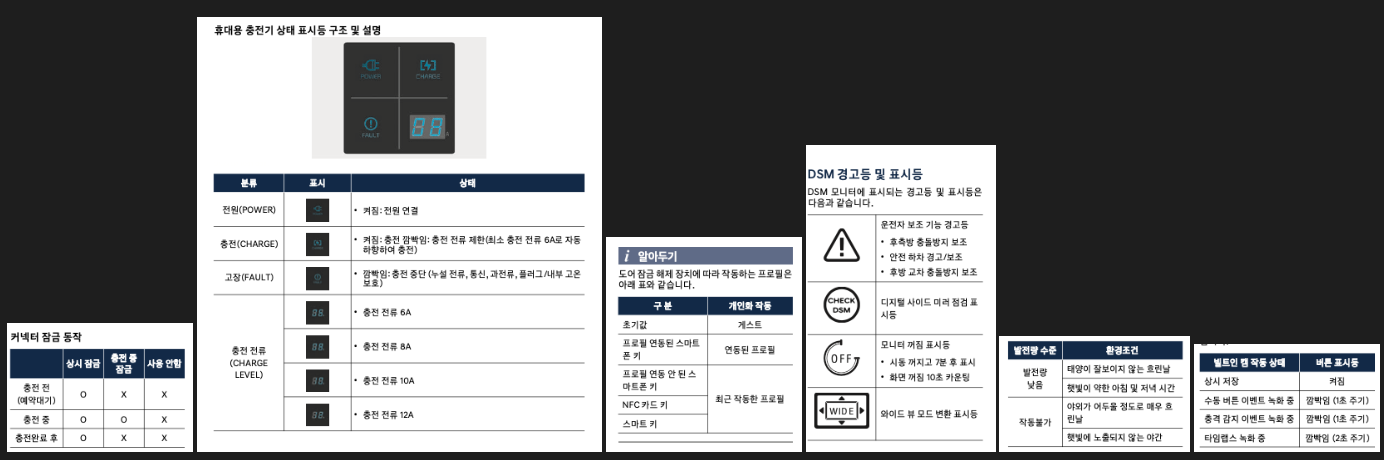

In [9]:
FILE_NM = "./pdf/2024 아이오닉 5 (IONIQ 5) NE.pdf"
page_num=243

In [2]:
import tabula
import pdfplumber

In [168]:
incorrect_list = []
not_same_shape_list = []
pdf = pdfplumber.open(FILE_NM)
doc = fitz.open(FILE_NM)
for page_num in tqdm(range(7, doc.page_count)):
    page = doc.load_page(page_num)
    pymu_tbls = page.find_tables().tables
    plumber_tbls = pdf.pages[page_num].extract_tables()
    if len(pymu_tbls)>0:
        if len(pymu_tbls) != len(plumber_tbls):
            not_same_shape_list.append((page_num, pymu_tbls, plumber_tbls))
            continue
        for mutbl, pltbl in zip(pymu_tbls, plumber_tbls):
            if 'cid' in str(pltbl):
                continue
            mutbl_columns = mutbl.header.names
            pltbl_columns = pltbl[0]
            if mutbl_columns != pltbl_columns:
                mutbl_df = mutbl.to_pandas()
                if len(mutbl_columns) == len(pltbl_columns):
                    mutbl_df.columns = pltbl_columns
                    mutbl_df = mutbl_df.loc[1:].reset_index(drop=True)
                else:
                    incorrect_list.append((page_num, mutbl_df, pltbl))
            else:
                pass
            
    

100%|██████████| 594/594 [01:00<00:00,  9.78it/s]


In [4]:
from ctypes.util import find_library
find_library("gs")

'/Users/yj/lib/libgs.dylib'

In [50]:
import camelot
tables = camelot.read_pdf(FILE_NM, flavor='lattice', pages='27')

In [51]:
tables[0].parsing_report

{'accuracy': 0, 'whitespace': 100.0, 'order': 1, 'page': 27}

In [57]:
tables[1].df

,0,1,2,3,4,5,6
0,충전 도어 직접 터치,,,,,,
1,,,,,,,
2,,ONE1Q011064,,,ONE1Q011067,,
3,스마트키,,,,,,
4,,,,,,,
5,,ONE1Q011066,,,,,
6,블루링크 어플리케이션,,,,,,
7,,,,,,,
8,,,,,,,
9,,ONE1Q011065,,,,,


/var/folders/49/sp_nrcwj4cl4wq36jvgbh38h0000gn/T/ipykernel_10592/1356449381.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[1], kind='grid').show()


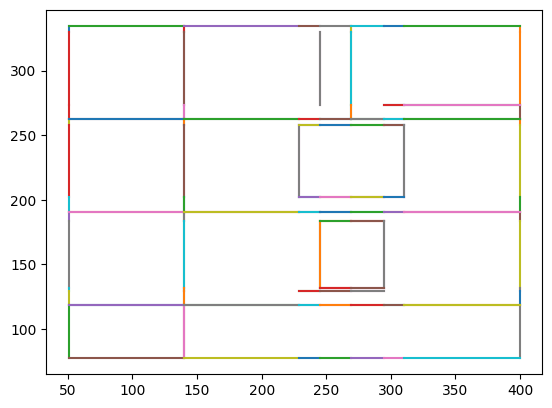

In [58]:
camelot.plot(tables[1], kind='grid').show()


/var/folders/49/sp_nrcwj4cl4wq36jvgbh38h0000gn/T/ipykernel_10592/645181575.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[1], kind='contour').show()


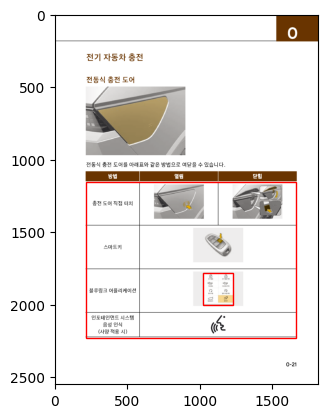

In [61]:
camelot.plot(tables[1], kind='contour').show()


/var/folders/49/sp_nrcwj4cl4wq36jvgbh38h0000gn/T/ipykernel_10592/2894074081.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[0], kind='line').show()


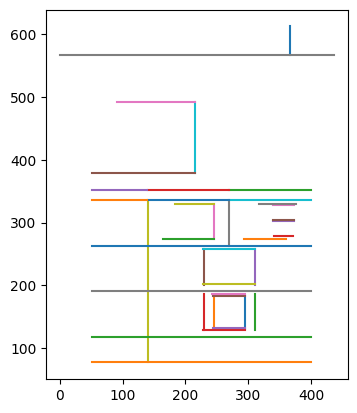

In [62]:
camelot.plot(tables[0], kind='line').show()


In [66]:
import fitz

In [67]:
doc = fitz.open(FILE_NM)

In [173]:
from tqdm import tqdm

In [482]:
page = doc.load_page(43)
tables = page.find_tables().tables

In [483]:
tables[0].to_pandas()

,고장코드,항목,현상
0,E1,CP (충전제어 신호) 통신,차량통신 오류 발생
1,E2,누설,누설 전류 발생
2,E3,None,충전기 오류 발생
3,E4,플러그 온도,플러그 과온 경고
4,E5,None,플러그 온도 이상(급격한 온도상승)
5,E6,None,충전기 오류 발생
6,E7,과전류,충전 과전류 경고
7,E8,내부 온도,충전기 과열
8,E9,None,충전기 오류 발생
9,F1,릴레이 용착,충전기 오류 발생


In [480]:
tables

<TableList n=1>

In [395]:
x0, y0, x1, y1 = tables[1].bbox

In [478]:
tables = camelot.read_pdf(FILE_NM, flavor='stream', pages=f'44', table_area=["44.7224, 221.0874, 369.6974, 579.5183999999999"])

In [479]:
tables[0].df

,0,1,2
0,전기차 시작하기,,
1,고장코드,항목,현상
2,E1,CP (충전제어 신호) 통신,차량통신 오류 발생
3,E2,,누설 전류 발생
4,,누설,
5,E3,,충전기 오류 발생
6,E4,,플러그 과온 경고
7,E5,플러그 온도,플러그 온도 이상(급격한 온도상승)
8,E6,,충전기 오류 발생
9,E7,과전류,충전 과전류 경고


In [474]:
tables[0]._bbox

(44.7224, 221.0874, 369.6974, 579.5183999999999)

/var/folders/49/sp_nrcwj4cl4wq36jvgbh38h0000gn/T/ipykernel_10592/311955129.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[0], kind='grid').show()


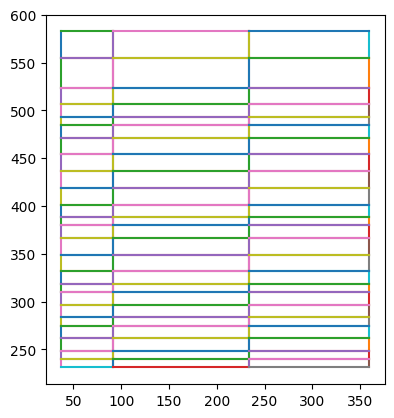

In [475]:
camelot.plot(tables[0], kind='grid').show()

In [458]:
tables

<TableList n=0>

In [453]:
tables[1]._bbox

(50.64081243124312, 165.62029411764706, 399.60641089108907, 389.327705882353)

In [438]:
tables[0].df.loc[5]

0    에 따라 지상파 DMB 수신이 안 될 수 있습니
1                              
2       먼트 시스템으로 TV나 비디오를 시청할 수
Name: 5, dtype: object

In [412]:
tables[0]._bbox

(220.80354235423542, 416.45102941176475, 385.4461837183718, 530.2249705882354)

In [372]:
table_regions

<TableList n=0>

In [377]:
from camelot import utils
layout, dim = utils.get_page_layout(FILE_NM)

In [381]:
page_width, page_height

(436.3269958496094, 612.0750122070312)

In [378]:
layout

<LTPage(601) 0.000,0.000,436.327,612.075 rotate=0>

In [379]:
dim

(436.327, 612.075)

In [334]:
tables[1].df

IndexError: list index out of range

In [311]:
tbl_list = []
for i in tqdm(range(0,doc.page_count)):
    page = doc.load_page(i)
    if len(page.find_tables().tables)==0:
        continue
    page_i = i+1

    tables = camelot.read_pdf(FILE_NM, flavor='lattice', pages=f'{page_i}', split_text=True, copy_text=['v', 'h'])
    if tables.n>0:
        for tbl_idx in range(tables.n):
           tbl_list.append({'page': i, 'table_idx':tbl_idx, 'table':tables[tbl_idx].df}) 

100%|██████████| 601/601 [01:59<00:00,  5.01it/s]


In [312]:
import pandas as pd
import re
from copy import deepcopy

In [313]:
tbl_list_bak = deepcopy(tbl_list)

In [290]:
tbl_list = tbl_list_bak.copy()

In [314]:
tbl_list = list(filter(lambda x: not (x['table']=='').all().all(), tbl_list))

In [315]:
def contains_image_name(text):
    # pattern = re.compile(r'^(?=.*[A-Z])(?=.*\d)[A-Z\d]+$')
    pattern = re.compile(r'^(?=.*[A-Z])(?=.*\d)[A-Z\d]+$')
    pattern2 = re.compile(r'^(?=.*[A-Z])(?=.*\d)+$')
    matched = (bool(pattern.match(text))) or (bool(pattern2.match(text)))
    return matched

In [323]:
for tbl in tbl_list:
    tmp_df = tbl['table']
    img_index = tmp_df.applymap(lambda x: contains_image_name(x))
    tmp_df[img_index] = ''
    tmp_df = tmp_df.drop_duplicates()
    tbl['table'] = tmp_df
    if img_index.sum().sum()>0:
        tbl['img_include']= True
    else:
        tbl['img_include']= False
    if (tmp_df.iloc[:,1:]=='').all().all():
        tbl['empty'] = True
    else:
        tbl['empty'] = False

In [327]:
for tbl in tbl_list:
    print(tbl['page'], tbl['table_idx'])
    display(tbl['table'])
    print('empty')
    display(tbl['empty'])

21 0


,0,1,2,3
0,완속 충전,완속 충전,상온에서 8시간 55분 소요 \n(100%까지 충전 가능),상온에서 11시간 45분 소요 \n(100%까지 충전 가능)
1,급속 충전,350KW급 \n충전기,"상온에서 18분 소요 \n(80%기준, 100%까지 충전 가능)","상온에서 18분 소요 \n(80%기준, 100%까지 충전 가능)"
2,급속 충전,50KW급 \n충전기,"상온에서 63분 소요 \n(80%기준, 100%까지 충전 가능)","상온에서 73분 소요 \n(80%기준, 100%까지 충전 가능)"
3,휴대용 충전,휴대용 충전,상온에서 약 25시간 50분 이내로 소요 \n(100%까지 충전 가능),상온에서 약 34시간 25분 이내로 소요 \n(100%까지 충전 가능)


empty


False

22 0


,0,1,2,3,4,5,6,7,8,9
0,충전 인렛 \n(차량),,,,,,,,,
3,충전 커넥터,,,,,,,,,
8,충전 전원,,,,,,,,,
13,충전 방법,공공 충전소의 완속 충전기 \n이용,공공 충전소의 완속 충전기 \n이용,공공 충전소의 완속 충전기 \n이용,공공 충전소의 급속 충전기 \n이용,공공 충전소의 급속 충전기 \n이용,공공 충전소의 급속 충전기 \n이용,가정용 전기 사용,가정용 전기 사용,가정용 전기 사용
14,충전 시간,기본형: 약 9시간 \n항속형: 약 11시간 45분 \n※ 100% 까지 충전 가능,기본형: 약 9시간 \n항속형: 약 11시간 45분 \n※ 100% 까지 충전 가능,기본형: 약 9시간 \n항속형: 약 11시간 45분 \n※ 100% 까지 충전 가능,"기본형: 약 18분(350kW), \n약 63분(50kW) \n항속형: 약 18분(...","기본형: 약 18분(350kW), \n약 63분(50kW) \n항속형: 약 18분(...","기본형: 약 18분(350kW), \n약 63분(50kW) \n항속형: 약 18분(...",기본형: 약 26시간 \n항속형: 약 34시간 25분 \n※ 100% 까지 충전 가능,기본형: 약 26시간 \n항속형: 약 34시간 25분 \n※ 100% 까지 충전 가능,기본형: 약 26시간 \n항속형: 약 34시간 25분 \n※ 100% 까지 충전 가능


empty


False

23 0


,0,1
0,,0 ~ 20
1,,21 ~ 40
2,,41 ~ 60
3,,61 ~ 80
4,,81 ~ 100


empty


False

24 0


,0,1,2,3
0,충전 전\n(예약대기),O,X,X
1,충전 중,O,O,X
2,충전완료 후,O,X,X


empty


False

26 1


,0,1,2,3,4,5,6
0,충전 도어 직접 터치,,,,,,
3,스마트키,,,,,,
6,블루링크 어플리케이션,,,,,,
10,인포테인먼트 시스템 \n음성 인식 \n(사양 적용 시),,,,,,


empty


True

38 0


,0,1,2,3,4
0,14~16A,,,,
2,13~12A,,,,
3,11~10A,,,,
4,9~8A,,,,


empty


True

42 1


,0,1,2
0,전원(POWER),,• 켜짐: 전원 연결
1,충전(CHARGE),,• 켜짐: 충전 깜빡임: 충전 전류 제한(최소 충전 전류 6A로 자동\n하향하여 충전)
2,고장(FAULT),,"• 깜빡임: 충전 중단 (누설 전류, 통신, 과전류, 플러그/내부 고온\n보호)"
3,충전 전류 \n(CHARGE \nLEVEL),,• 충전 전류 6A
4,충전 전류 \n(CHARGE \nLEVEL),,• 충전 전류 8A
5,충전 전류 \n(CHARGE \nLEVEL),,• 충전 전류 10A
6,충전 전류 \n(CHARGE \nLEVEL),,• 충전 전류 12A


empty


False

43 0


,0,1,2
0,,CP (충전제어 신호) 통신,차량통신 오류 발생
1,,누설,누설 전류 발생
2,,누설,충전기 오류 발생
3,,플러그 온도,플러그 과온 경고
4,,플러그 온도,플러그 온도 이상(급격한 온도상승)
5,,플러그 온도,충전기 오류 발생
6,,과전류,충전 과전류 경고
7,,내부 온도,충전기 과열
8,,내부 온도,충전기 오류 발생
9,,릴레이 용착,충전기 오류 발생


empty


False

44 1


,0,1,2,3,4,5,6
0,1,,,,,,• 전원 플러그 연결(POWER 녹색 켜짐)
4,2,,,,,,• 충전 커넥터 차량 연결(POWER 녹색 켜짐)
8,3,,,,,,"• 충전 중(POWER 녹색, CHARGE 파란색 켜짐)\n• 충전 전류 표시"
12,4,,,,,,"• 차량 연결 전(POWER 녹색 켜짐, FAULT 적색 깜빡임) \n- 플러그/내..."
16,5,,,,,,"• 차량 연결 후(POWER 녹색 켜짐, FAULT 적색 깜빡임) \n- 내부 진단..."
20,6,,,,,,"• 누설 전류 고장 발생 시(POWER 녹색, FAULT 적색 깜빡임)\n• 전원 ..."
24,7,,,,,,• 절전 모드\n1분 이상 상태 변경 없으면 7segment 디스플레이 꺼짐


empty


False

71 0


,0,1,2
0,전장,"4,635 mm","4,635 mm"
1,전폭,"1,890 mm","1,890 mm"
2,전고,"1,605 mm","1,605 mm"
3,축거,"3,000 mm","3,000 mm"
4,윤거\n235/55R19\n255/45R20,전륜\n1638 mm\n1628 mm,후륜\n1647 mm\n1637 mm


empty


False

73 0


,0,1
0,S,180 km/h(112 mph)
1,T,190 km/h(118 mph)
2,H,210 km/h(130 mph)
3,V,240 km/h(149 mph)
4,W,270 km/h(168 mph)
5,Y,300 km/h(186 mph)


empty


False

74 0


,0,1,2,3
0,차량 앞,하향등\n전조등\n상향등,LED\nLED,LED\nLED
2,차량 앞,방향 지시등,STD: PY21W,STD: 21W
3,차량 앞,방향 지시등,OPT: LED,OPT: LED
4,차량 앞,차폭등,LED,LED
5,차량 앞,주간 주행등,LED,LED
6,차량 앞,프론트 가니쉬 램프,LED,LED
7,차량 앞,충전 표시등,LED,LED
8,차량 앞,프론트 트렁크,LED,LED
9,차량 뒤,제동등,LED,LED
10,차량 뒤,미등,LED,LED


empty


False

75 0


,0,1,2,3,4
0,배터리,배터리,배터리,-,전기 배터리
1,감속기 오일,,후륜,약 3.4~3.5,HK ATF 6S SP4M-1
2,감속기 오일,,전륜,약 3.2~3.3,HK ATF 6S SP4M-1
4,브레이크 오일,브레이크 오일,브레이크 오일,필요량,"SAE J1704 DOT-4 LV, FMVSS 116 DOT-4, \nISO4925..."
5,일반 냉각수,기본형,,약 6.4,※ 자세한 추천 사양은 가까운 당사 직영 하\n이테크센터나 블루핸즈에 문의하십시오.
6,일반 냉각수,기본형,,약 6.8,※ 자세한 추천 사양은 가까운 당사 직영 하\n이테크센터나 블루핸즈에 문의하십시오.
7,일반 냉각수,향속형,,약 6.4,※ 자세한 추천 사양은 가까운 당사 직영 하\n이테크센터나 블루핸즈에 문의하십시오.
8,일반 냉각수,향속형,,약 6.8,※ 자세한 추천 사양은 가까운 당사 직영 하\n이테크센터나 블루핸즈에 문의하십시오.
9,저전도 냉각수,기본형,,약 9.4,※ 자세한 추천 사양은 가까운 당사 직영 하\n이테크센터나 블루핸즈에 문의하십시오.
11,저전도 냉각수,향속형,,약 11.2,※ 자세한 추천 사양은 가까운 당사 직영 하\n이테크센터나 블루핸즈에 문의하십시오.


empty


False

134 0


,0,1,2,3
0,1. 성인 *1,꺼짐,꺼짐,작동
1,2. 어린이 보조 좌석에 앉힌 12\n개월 어린이*3*4 또는 유아 *2,켜짐,꺼짐,미작동
2,3. 공석,켜짐,꺼짐,미작동
3,4. 시스템 오류,꺼짐,켜짐,작동


empty


False

168 0


,0,1,2
0,(모드),짧게 누름,뷰 모드 전환
1,"∧, ∨ (상, 하)",짧게 누름,"유틸리티 탐색, 옵션 메뉴 탐색"
2,OK (확인),짧게 누름,옵션 메뉴로 이동
3,OK (확인),길게 누름,• 도움말 팝업 표시 \n• 일부 메뉴 정보 초기화


empty


False

195 0


,0,1
0,초기값,게스트
1,프로필 연동된 스마트\n폰 키,연동된 프로필
2,프로필 연동 안 된 스\n마트폰 키,최근 작동한 프로필
3,NFC 카드 키,최근 작동한 프로필
4,스마트 키,최근 작동한 프로필


empty


False

196 0


,0,1,2
0,사용자 설정,HUD,"디스플레이 모드, 영상 위치 조정, 증강현실 매칭 조정, 표시 정보 선\n택"
1,사용자 설정,램프,원터치 방향 지시등 횟수
2,사용자 설정,클러스터,"클러스터 표시 정보, 음성 볼륨, 웰컴 사운드"
3,사용자 설정,시트/미러/ \n스티어링 휠,"시트 위치, 실외 미러 위치, 승하차 편의 기능"
4,사용자 설정,시트/미러/ \n스티어링 휠,스마트 열선/통풍 설정
5,사용자 설정,도어,"도어 자동 잠금, 도어 자동 잠금 해제, 세이프티 언락 기능 설정"
6,사용자 설정,무선 충전,무선 충전 작동 설정
7,사용자 설정,공조,"온도 단위, 외부 공기 차단, 자동 환기, 창문 습기 방지, 공조 편의 설\n정"
8,인포테인먼\n트 설정 메뉴,내비게이션,내비게이션 선호 음량
9,인포테인먼\n트 설정 메뉴,내비게이션,최근 목적지


empty


False

221 0


,0,1
0,WNE1-213,운전자 보조 기능 경고등\n• 후측방 충돌방지 보조\n• 안전 하차 경고/보조\n•...
1,WNE1-214,디지털 사이드 미러 점검 표\n시등
2,OFF\nWNE1-212,모니터 꺼짐 표시등\n• 시동 꺼지고 7분 후 표시\n• 화면 꺼짐 10초 카운팅
3,WIDE\nWNE1-211,와이드 뷰 모드 변환 표시등


empty


False

233 0


,0,1,2,3,4
0,버튼 \n작동,잔액 확인,(할인)선불카드 : 딩동~ 잔액이 0000원입\n니다. \n(할인)후불카드 : 딩동...,"정상, 이상 작\n동의 LED 상\n태를 따름",짧게 입력 시
1,버튼 \n작동,잔액 확인,딩동~ 최근 거래요금은 0000원입니다.,"정상, 이상 작\n동의 LED 상\n태를 따름",길게(1.5초) \n입력 시
2,버튼 \n작동,잔액 확인,단말기 정보 안내 시 다음정보 안내,"정상, 이상 작\n동의 LED 상\n태를 따름",짧게 입력 시
3,버튼 \n작동,"잔액, 전원/\n볼륨 동시",딩동~ 소프트웨어 버전은 X.XX 입니다. \n딩동~ 하드웨어 버전은 HK XXXX...,"정상, 이상 작\n동의 LED 상\n태를 따름",길게(1.5초) \n동시 입력 시
4,버튼 \n작동,전원/볼륨,(전원 ON/OFF 제어) OFF → ON,"정상, 이상 작\n동의 LED 상\n태를 따름",짧게 또는 길\n게(1.5초) 입\n력 시
5,버튼 \n작동,전원/볼륨,"“음량1”, “음량2”, “음량3”, “음량4”, “음\n량0” (해당 볼륨 크기로...","정상, 이상 작\n동의 LED 상\n태를 따름",짧게 입력 시
6,버튼 \n작동,전원/볼륨,(전원 ON/OFF 제어) ON → OFF,LED OFF,길게(1.5초) \n입력 시


empty


False

234 0


,0,1,2
0,1,제조번호,ETCS 단말기 제조회사에\n서 부여하는 번호
1,2,발행번호,ETCS 단말기를 등록할 때 \n부여하는 번호
2,3,차종,ETCS 단말기 등록 시 등록\n한 차량의 차종
3,4,차량번호,-
4,5,발행일,ETCS 단말기 발행일자 \n(YYYYMMDD)
5,6,만료일,ETCS 단말기 만료일자 \n(YYYYMMDD)


empty


False

243 1


,0,1
0,발전량 \n미세감소,먼지로 인해 솔라루프가 오염\n된 경우
1,발전량 \n감소,그림자가 솔라루프를 부분적으\n로 가릴 경우 (가로수/신호등/\n건물그림자 등)
2,발전량 \n감소,솔라루프 온도가 과도하게 상\n승할 경우
3,작동불가,차량이 실내 주차장 또는 터널 \n내부에 위치할 경우
4,작동불가,겨울철 눈으로 인해 솔라루프\n가 충분히 덮인 경우
5,작동불가,물체가 솔라루프에 근접하여 \n직접적으로 가릴 경우


empty


False

269 0


,0,1
0,운전자 1명,0
1,운전자 1명 + 동승자 1명,0
2,운전자 포함 5명,1
3,운전자 포함 5명 + 테일게이\n트 적재,2
4,운전자 + 테일게이트 적재,3


empty


False

282 2


,0,1,2,3
0,3단,,HIGH,1~8단
2,2단,,MEDIUM,1~6단


empty


False

283 0


,0,1,2,3
0,1단,,LOW,1~4단


empty


False

285 0


,0,1,2
0,,"상반신, 얼굴쪽으로 바람이 나옵니다. (일반적으로 냉방을 할 때\n의 위치입니다.)","B, D, F"
1,,얼굴쪽과 발끝으로 바람을 원할 때 사용합니다.,"B, C, D, E, F"
2,,주로 발끝으로 바람이 나오게 할 때 사용합니다.(일반적으로 난방\n을 할 때의 위치...,"A, C, E, D"
3,,발끝으로 바람이 나오게 함과 동시에 앞 유리 습기를 제거할 때 사\n용합니다. (유...,"A, C, E, D"


empty


False

292 0


,0,1,2,3,4,5
0,,실내공기상태,좋음(블루),보통(그린),나쁨(오렌지),매우 나쁨(레\n드)
1,,농도(㎍/m³),15 이하,35 이하,75 이하,76 이상


empty


False

365 0


,0,1,2,3,4
0,특색,눈길 주행 모드,일반적인 \n주행 모드,경제 운전에 최적\n화된 주행 모드,스포티한 \n주행 모드
1,버튼 조작,길게 누름,누름,누름,누름
2,클러스터 표시등,SNOW,NORMAL,ECO,SPORT
3,히터 및 에어컨(공\n조) 시스템 제어,NORMAL,NORMAL,ECO(ECO/NOR\nAMAL) *¹,NORMAL
4,회생 제동 단계,0~1 단계,0~3 단계 (드라이브 모드 상관없이 기존값 유지),0~3 단계 (드라이브 모드 상관없이 기존값 유지),0~3 단계 (드라이브 모드 상관없이 기존값 유지)
5,브레이크 모드,NORMAL/SPOR\nT *¹,NORMAL/SPOR\nNORMAL/SPOR\nNORMAL/SPOR\nT *¹\nT...,NORMAL/SPOR\nNORMAL/SPOR\nNORMAL/SPOR\nT *¹\nT...,NORMAL/SPOR\nNORMAL/SPOR\nNORMAL/SPOR\nT *¹\nT...


empty


False

493 1


,0,1,2
0,60 ~ \n120cm,,삐---삐\n---
1,30 ~ 60cm,,삐-삐-\n삐-
2,30cm 이내,,삐\n(연속음)


empty


False

497 0


,0,1,2
0,60 ~ \n120cm,,삐---삐\n---
1,30 ~ 60cm,,삐-삐-\n삐-
2,30cm 이내,,삐\n(연속음)


empty


False

497 1


,0,1,2
0,60 ~ 100cm,,삐---삐\n---
1,30 ~ 60cm,,삐-삐-\n삐-
2,30cm 이내,,삐\n(연속\n음)


empty


False

506 0


,0,1,2,3
0,원격 전/후진,원격 전/후진,원격 전/후진,
1,원격 전/후진,원격 전/후진,,
2,원격 전/후진,,,
3,"스마트 주차, \n원격 스마트 \n주차",직각 후진 주차,직각 후진 주차,
4,"스마트 주차, \n원격 스마트 \n주차",직각 후진 주차,,
5,"스마트 주차, \n원격 스마트 \n주차",,,
6,"스마트 주차, \n원격 스마트 \n주차",평행 후진 주차,평행 후진 주차,
7,"스마트 주차, \n원격 스마트 \n주차",평행 후진 주차,,


empty


False

509 0


,0,1,2,3,4,5
0,,,,,,


empty


True

509 1


,0,1,2,3
0,실내,주차/뷰 버튼,,• 길게 누르면 원격 스마트 주차 보조 및 주차 거리 경고가\n켜짐(상황에 따라 작...
1,실내,주차 안전 버튼,,• 원격 스마트 주차 보조 작동 중 누르면 기능 종료
2,스마트 키,원격 시동 버튼,,• 시동이 꺼진 상태에서 스마트 키로 도어를 잠금 후 길게\n누르면 시동 걸림 작동...
3,스마트 키,전진 버튼,,• 원격 전/후진 기능 사용 시 누르고 있으면 해당 방향으로\n차량 이동\n• 원격...
4,스마트 키,후진 버튼,,• 원격 전/후진 기능 사용 시 누르고 있으면 해당 방향으로\n차량 이동\n• 원격...


empty


False

512 0


,0,1,2
0,제어 중,초록색 LED \n계속 깜빡임,-
1,일시 중지,빨간색 LED \n계속 깜빡임,깜빡임
2,해제,빨간색 LED \n4초 켜진 후 \n꺼짐,3회 깜빡인 후 \n꺼짐
3,완료,초록색 LED \n4초 켜진 후 \n꺼짐,1회 깜빡인 후 \n꺼짐


empty


False

518 0


,0,1,2,3
0,제어 \n중,초록색 \nLED \n깜빡임,-,첫 번째 후\n진 완료 시\n까지 주차 \n방향으로 \n방향지시\n등 깜빡임
1,일시 \n중지,빨간색 \nLED \n깜빡임,깜빡임,-
2,해제,빨간색 \nLED 4초 \n켜진 후 \n꺼짐,3회 깜\n빡인 후 \n꺼짐,-
3,완료,초록색 \nLED 4초 \n켜진 후 \n꺼짐,1회 깜빡\n인 후 \n꺼짐,-


empty


False

550 0


,0,1,2,3,4,5,6,7,8,9
0,KBS,표준,97.3,94.7,101.3,103.7,90.5,96.9,97.1,98.9
1,MBC,,91.9,97.5,95.3,88.9,91.5,99.1,98.9,94.3
2,MBC,표준\nFM,95.9,92.5,96.5,95.9,93.9,94.3,92.7,96.3
3,SBS(지역민방),SBS(지역민방),107.7,95.7,99.3,99.9,101.1,90.1,105.1,106.1
4,교통방송,교통방송,95.1,102.9,103.9,94.9,97.3,102.5,105.9,105.5


empty


False

557 0


,0,1,2
0,이상 유무 확인,이상 유무 확인,• 전일 운전 시 이상이 있던 부분은 정상인가
1,모터룸,구동 모터,"• 시동이 잘 걸리고 냉각수가 충분한가\n• 누수, 누유가 없는가"
2,모터룸,기타,"• 브레이크 오일, 와셔액이 충분하고 누유는 없는가"
3,차량 외관,완충 스프링,• 스프링의 연결 부위에 손상이나 균열이 없는가
4,차량 외관,감속기,• 누유는 없는가
5,차량 외관,바퀴,• 타이어의 공기압은 적당한가\n• 타이어에 비정상적인 마모 또는 손상이 없는가\n...
6,차량 외관,램프,• 깜빡임이 확실하고 파손되지 않았는가
7,차량 외관,차량 번호판,• 번호판이 파손되지 않았는가
8,운전석,배터리,• 보조 배터리(12 V) 충전량은 충분한가\n• 구동용(고전압) 배터리의 흔들림 ...
9,운전석,스티어링 휠,• 흔들림이나 움직임이 없는가 조작이 수월한가


empty


False

559 0


,0,1,2,3,4,5,6,7,8,9,10
0,일반 냉각수량 점검 및 교환,○,"최초 교환: 20만km 또는 10년, 최초 교환 후: 매 4만km 또는 2\n년 마...","최초 교환: 20만km 또는 10년, 최초 교환 후: 매 4만km 또는 2\n년 마...","최초 교환: 20만km 또는 10년, 최초 교환 후: 매 4만km 또는 2\n년 마...","최초 교환: 20만km 또는 10년, 최초 교환 후: 매 4만km 또는 2\n년 마...","최초 교환: 20만km 또는 10년, 최초 교환 후: 매 4만km 또는 2\n년 마...","최초 교환: 20만km 또는 10년, 최초 교환 후: 매 4만km 또는 2\n년 마...","최초 교환: 20만km 또는 10년, 최초 교환 후: 매 4만km 또는 2\n년 마...","최초 교환: 20만km 또는 10년, 최초 교환 후: 매 4만km 또는 2\n년 마...","최초 교환: 20만km 또는 10년, 최초 교환 후: 매 4만km 또는 2\n년 마..."
1,저전도 냉각수량 점검 및 교환,○,"매 60,000km 또는 36개월마다 교환 *1","매 60,000km 또는 36개월마다 교환 *1","매 60,000km 또는 36개월마다 교환 *1","매 60,000km 또는 36개월마다 교환 *1","매 60,000km 또는 36개월마다 교환 *1","매 60,000km 또는 36개월마다 교환 *1","매 60,000km 또는 36개월마다 교환 *1","매 60,000km 또는 36개월마다 교환 *1","매 60,000km 또는 36개월마다 교환 *1"
2,"각종 오일 누유, 냉각장치의 \n누수 여부",○,,,,,,,,,
3,보조 배터리(12 V) 터미널 조\n임 상태 점검,○,,,,,,,,,
4,보조 배터리(12 V) 터미널 녹 \n발생 점검,○,,,,,,,,,
5,보조 배터리(12 V) 고정 상태 \n점검,○,,,,,,,,,
6,보조 배터리(12 V) 상태,○,,,,,,,,,
7,각종 전기장치 점검,,,,○,,,,,,
8,감속기 오일,,,,,,○,,,○,
9,브레이크 오일,○,"매 50,000 km 마다 교환","매 50,000 km 마다 교환","매 50,000 km 마다 교환","매 50,000 km 마다 교환","매 50,000 km 마다 교환","매 50,000 km 마다 교환","매 50,000 km 마다 교환","매 50,000 km 마다 교환","매 50,000 km 마다 교환"


empty


False

560 0


,0,1,2,3,4,5,6,7,8,9,10
0,드라이브 샤프트와 부트,○,○,○,○,○,○,○,○,○,○
1,휠 너트의 조임상태,○,○,○,○,○,○,○,○,○,○
2,브레이크 페달 유격,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정
3,현가 장치 점검\n(볼트 및 너트 조임 토크),,○,,,,,,,,
4,"볼 조인트류 점검 \n(로워암, 스텝바 링크)",,○,,,,,,,,
5,"도어 체커, 각 잠금장치, 각 힌\n지부 점검주유",,○,,,,,,,,
6,앞 바퀴 정렬상태,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정,상태에 따라 수시 점검 및 수정
7,공조 장치용 에어필터 \n(모터룸),"매 15,000km 마다 교환","매 15,000km 마다 교환","매 15,000km 마다 교환","매 15,000km 마다 교환","매 15,000km 마다 교환","매 15,000km 마다 교환","매 15,000km 마다 교환","매 15,000km 마다 교환","매 15,000km 마다 교환","매 15,000km 마다 교환"
8,에어컨 냉매 점검 및 작동상\n태 점검,매 12개월 마다 점검,매 12개월 마다 점검,매 12개월 마다 점검,매 12개월 마다 점검,매 12개월 마다 점검,매 12개월 마다 점검,매 12개월 마다 점검,매 12개월 마다 점검,매 12개월 마다 점검,매 12개월 마다 점검


empty


False

561 0


,0,1,2,3
0,브레이크 디스크 및 패드,○,상태에 따라 수시 점검,"2, 4, 5, 6, 7, 8, 9, 10"
1,로워암 볼 조인트 청소,○,상태에 따라 수시 점검,"2, 3, 4, 5, 9"
2,드라이브 샤프트와 부트,○,상태에 따라 수시 점검,"2, 3, 4, 5, 6, 7, 8, 9, 10"
3,공조 장치용 에어 필터,●,상태에 따라 수시 점검,2
4,감속기 오일,●,"매 120,000 km 교환","1, 3, 4, 5, 6"


empty


False

562 0


,0,1,2
0,-15,35%,65%
1,-25,40%,60%
2,-35,50%,50%
3,-45,60%,40%


empty


False

575 1


,0,1
0,S,180 km/h (112 mph)
1,T,190 km/h (118 mph)
2,H,210 km/h (130 mph)
3,V,240 km/h (149 mph)
4,W,270 km/h (168 mph)
5,Y,300 km/h (186 mph)


empty


False

In [168]:
tables = camelot.read_pdf(FILE_NM, 
                          flavor='lattice', pages='293', split_text=False, copy_text=['v', 'h'])
#, copy_text=['v']

In [169]:
tables[0].df

,0,1,2,3,4,5
0,,실내공기상태,좋음(블루),보통(그린),나쁨(오렌지),매우 나쁨(레\n드)
1,,농도(㎍/m³),15 이하,35 이하,75 이하,76 이상


In [145]:
tables[0].df

,0,1,2,3
0,차량 앞,하향등\n전조등\n상향등,LED\nLED,LED\nLED
1,차량 앞,하향등\n전조등\n상향등,LED\nLED,LED\nLED
2,차량 앞,방향 지시등,STD: PY21W,STD: 21W
3,차량 앞,방향 지시등,OPT: LED,OPT: LED
4,차량 앞,차폭등,LED,LED
5,차량 앞,주간 주행등,LED,LED
6,차량 앞,프론트 가니쉬 램프,LED,LED
7,차량 앞,충전 표시등,LED,LED
8,차량 앞,프론트 트렁크,LED,LED
9,차량 뒤,제동등,LED,LED


In [134]:
import tabula


In [133]:
tables[tables.n-1].df

,0,1,2,3
0,차량 앞,하향등\n전조등\n상향등,LED\nLED,LED\nLED
1,,,,
2,,방향 지시등,STD: PY21W,STD: 21W
3,,,OPT: LED,OPT: LED
4,,차폭등,LED,LED
5,,주간 주행등,LED,LED
6,,프론트 가니쉬 램프,LED,LED
7,,충전 표시등,LED,LED
8,,프론트 트렁크,LED,LED
9,차량 뒤,제동등,LED,LED


In [123]:
tables[tables.n-1].df

,0,1,2,3,4,5,6
0,,,,,,,
1,1,,,,,,• 전원 플러그 연결(POWER 녹색 켜짐)
2,,,,,,,
3,,,ONX4EPHQ011005L,,,,
4,,,,,,,
5,2,,,,,,• 충전 커넥터 차량 연결(POWER 녹색 켜짐)
6,,,,,,,
7,,,ONX4EPHQ011005L,,,,
8,,,,,,,
9,3,,,,,,"• 충전 중(POWER 녹색, CHARGE 파란색 켜짐)\n• 충전 전류 표시"


/var/folders/49/sp_nrcwj4cl4wq36jvgbh38h0000gn/T/ipykernel_10592/2894074081.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[0], kind='line').show()


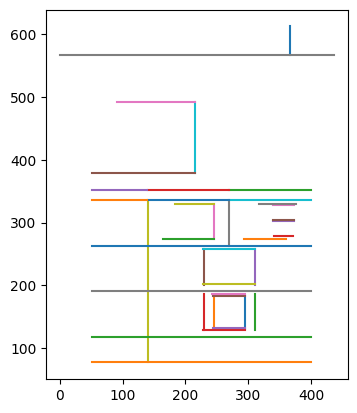

In [78]:
camelot.plot(tables[0], kind='line').show()


In [ ]:
for num in range(len(incorrect_list)):
    print(num)
    print(incorrect_list[num][0])
    print(incorrect_list[num][1].columns.tolist())
    print(incorrect_list[num][2][0])
    print('============')

In [170]:
for num in range(len(incorrect_list)):
    print(num)
    print(incorrect_list[num][0])
    print(incorrect_list[num][1].columns.tolist())
    print(incorrect_list[num][2][0])
    print('============')

0
74
['전구의 용량', 'Col1', 'Col2']
['종 류', None, None, '전구 형식', '용량']
1
196
['시스템', '개인화 작동', 'Col2']
['시스템', '개인화 작동']
2
292
['작업 표시등', '공기청정모드', 'OFF', 'Col3', 'ON', 'Col5']
['작업 표시등', '공기청정모드', 'OFF', None, 'ON']
3
597
['앞좌석 램프 5-101 화물칸 램프 5-103 아', '열선 시트 3-19 통풍 시트 3-22 올바른 운전 자세 2-3 와셔액 9-14 와셔액 점검 및 보충 9-14']
['']


In [72]:



page = doc.load_page(260)
tbls = page.find_tables().tables
tbl = tbls[0]


In [73]:
tbl.to_pandas()

,습니다.,Col1
0,빌트인 캠 작동 상태,버튼 표시등
1,상시 저장,켜짐
2,수동 버튼 이벤트 녹화 중,깜빡임 (1초 주기)
3,충격 감지 이벤트 녹화 중,깜빡임 (1초 주기)
4,타임랩스 녹화 중,깜빡임 (2초 주기)


In [55]:
tbl.bbox

(235.19039916992188, 103.86732025146485, 399.58348846435547, 191.5918172200521)

In [54]:
tbl.header.cells

[(235.19039916992188, 88.2418212890625, 328.7865702311198, 103.86732025146485),
 (328.7865702311198, 88.2418212890625, 399.58348846435547, 103.86732025146485)]

In [43]:
tbls[0].to_pandas()

,습니다.,Col1
0,빌트인 캠 작동 상태,버튼 표시등
1,상시 저장,켜짐
2,수동 버튼 이벤트 녹화 중,깜빡임 (1초 주기)
3,충격 감지 이벤트 녹화 중,깜빡임 (1초 주기)
4,타임랩스 녹화 중,깜빡임 (2초 주기)


In [229]:
spans_list = []
contents_list = []
image_url_list = []
contents_type = []
block_list = []
dpi = 300
size_ratio = 1.3
prev_text = ""    

doc = fitz.open(FILE_NM)
doc2 = fitz.open(FILE_NM)

page = doc.load_page(page_num)
draw_page = doc2.load_page(page_num)
text_rotation = is_text_rotated(page)

table_areas_on_page = {}
tbls = []
for i, tbl in enumerate(page.find_tables().tables):
    table_areas_on_page[i] = get_rotated_bbox(page, fitz.Rect(tbl.bbox))
    tbls.append(tbl.to_pandas())


if text_rotation:
    page.set_rotation(90)
    draw_page.set_rotation(90)
is_two_column = analyze_page_layout(page, text_rotation)
blocks = page.get_text("dict")["blocks"]  # Get text blocks
blocks_sorted = sort_blocks(blocks, is_two_column, page.rect.width / 2, page.rotation)

r_tbls = []
for i, tbl in enumerate(page.find_tables().tables):
    r_tbls.append(tbl)


In [231]:
r_tbls[0].to_pandas()

,햇빛을 이용해 출되는 정도에,작동하는 솔라루프는 햇빛에 노 따라 발전량이 변합니다.
0,발전량 수준,환경조건
1,발전량\n낮음,태양이 잘보이지 않는 흐린날
2,None,햇빛이 약한 아침 및 저녁 시간
3,작동불가,야외가 어두울 정도로 매우 흐\n린날
4,None,햇빛에 노출되지 않는 야간


In [60]:
contents_list[0]

'|    | 햇빛을 이용해 출되는 정도에   | 작동하는 솔라루프는 햇빛에 노 따라 발전량이 변합니다.   |\n|---:|:------------------------------|:--------------------------------------------------------|\n|  0 | 발전량 수준                   | 환경조건                                                |\n|  1 | 발전량                        | 태양이 잘보이지 않는 흐린날                             |\n|    | 낮음                          |                                                         |\n|  2 |                               | 햇빛이 약한 아침 및 저녁 시간                           |\n|  3 | 작동불가                      | 야외가 어두울 정도로 매우 흐                            |\n|    |                               | 린날                                                    |\n|  4 |                               | 햇빛에 노출되지 않는 야간                               |'

In [59]:
contents_list[1]

'|    | 발전량 수준   | 사용조건                     |\n|---:|:--------------|:-----------------------------|\n|  0 | 발전량        | 먼지로 인해 솔라루프가 오염  |\n|    | 미세감소      | 된 경우                      |\n|  1 | 발전량        | 그림자가 솔라루프를 부분적으 |\n|    | 감소          | 로 가릴 경우 (가로수/신호등/ |\n|    |               | 건물그림자 등)               |\n|  2 |               | 솔라루프 온도가 과도하게 상  |\n|    |               | 승할 경우                    |\n|  3 | 작동불가      | 차량이 실내 주차장 또는 터널 |\n|    |               | 내부에 위치할 경우           |\n|  4 |               | 겨울철 눈으로 인해 솔라루프  |\n|    |               | 가 충분히 덮인 경우          |\n|  5 |               | 물체가 솔라루프에 근접하여   |\n|    |               | 직접적으로 가릴 경우         |'

In [ ]:

prev_overlap_tbl_num=-1
for i, b in enumerate(blocks_sorted):
    overlapping=False
    block_num = f"{page_num}_{i}"
    bbox = b['bbox']  # Get the bounding box of the block
    caption = str(i + 1)
    if b['type'] == 0:  # Block contains text
        # 테이블 bbox안의 텍스트 block이라면 PASS
        block_area = b['bbox']  # 텍스트 블록의 영역 (x0, y0, x1, y1)
        
        for tbl_num, table_area in table_areas_on_page.items():
            if is_overlapping(block_area, table_area):
                overlapping=True
                if tbl_num != prev_overlap_tbl_num:
                    # print("TODO: PANDAS EXTACT, SAVE IMAGE")
                    spans_list.append(None)
                    content = get_tbl_df(tbls[tbl_num], text_rotation)
                    contents_list.append(content)
                    # Save Table Image
                    rect = fitz.Rect(r_tbls[tbl_num].bbox)
                    tab_bbox = get_rotated_bbox(page, rect)
                    # draw_page.draw_rect(tab_bbox,color=fitz.pdfcolor["blue"], width=1.5)
                    
                    img_url = save_table(draw_page, page_num, tbl_num, '', tab_bbox, 99, 99, tab_bbox[3]-tab_bbox[1], tab_bbox[2] - tab_bbox[0], 
                                'jpeg', size_ratio=1.3, dpi=300, text_rotation=text_rotation)

                    
                    image_url_list.append(img_url)
                    block_list.append(block_num)
                    contents_type.append('table')
                    prev_overlap_tbl_num = tbl_num
                    break
                else:
                    # print("테이블 추출 이미 완료")
                    break
    
                
        if overlapping:
            continue

        # TODO: INSERT ROW BY LINES
        
        if 'lines' in b:
            for line in b['lines']:
                line_text = ''.join(list(map(lambda x: x.get('text', ''), line['spans'])))
            
                line_spans = str(set(list(map(lambda x: str((x.get('font'), x.get('color'), int(x.get('size')))), 
                                                line['spans'])))).replace('{', '').replace('}', '')                    

                spans_list.append(line_spans)
                contents_list.append(line_text)
                image_url_list.append(None)
                contents_type.append('text')
                block_list.append(block_num)
        
            
        # Insert text on the pixmap
            # Reading order number as caption
        rect = fitz.Rect(bbox)  # Create a rectangle
        
        draw_page.insert_text(  # insert footer 50 points above page bottom
                (bbox[0], bbox[1]), caption, color=(1,0,0)
            )

        #이미지 캡션을 위해 한줄짜리 block인지 확인 후 저장
        text_lines = [span['text'] for line in b["lines"] for span in line["spans"]]
        text_lines = list(filter(lambda x: (x != '̰') and (x != ' ') and (x != '•'),text_lines))
        if len(text_lines) == 1:
            
            spans = b["lines"][0]["spans"][0]
            if not ((spans['size']==6) and (spans['font']=='HyundaiSansTextKR') and 
                    (spans['color']==16777215)):
                prev_text = text_lines[0]
    if b['type'] != 0:  # Block contains text
        block_area = b['bbox']
        for tbl_num, table_area in table_areas_on_page.items():
            if is_overlapping(block_area, table_area):
                overlapping=True
                break
        if overlapping:
            continue
        else:
            # Save Images
            xres = b['xres']  # PyMuPDF의 기본 해상도는 72 DPI입니다.
            yres = b['yres']
            ext = b['ext']
            width = b['width']
            height = b['height']
            
            img_url = save_image(draw_page, page_num, i, prev_text, bbox, xres, yres, width, height, ext, size_ratio=1.3, dpi=300)
            spans_list.append(None)
            contents_list.append(None)
            image_url_list.append(img_url)
            contents_type.append('image')
            block_list.append(block_num)
            prev_text = ""  # 이전 텍스트 초기화
            
pix = draw_page.get_pixmap()  # Render page to an image

# Convert the pixmap to a PIL Image
img_bytes = pix.tobytes("png")  # Get the image bytes in PNG format
img = Image.open(io.BytesIO(img_bytes))

# Display the image in the notebook
if display_pages_with_bboxes_and_captions:
    display(img)
# return blocks_sorted
return {'span': spans_list, 'contents': contents_list, 'img_urls': image_url_list, 'contents_type': contents_type, 'block_num': block_list}